<a href="https://colab.research.google.com/github/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human facial expression recognition

I am going to build a CNN to detect humans facial expressions from this [Kaggle dataset](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge), let's follow some steps:

1. Data analysis
2. Data preprocessing
3. Build CNN model


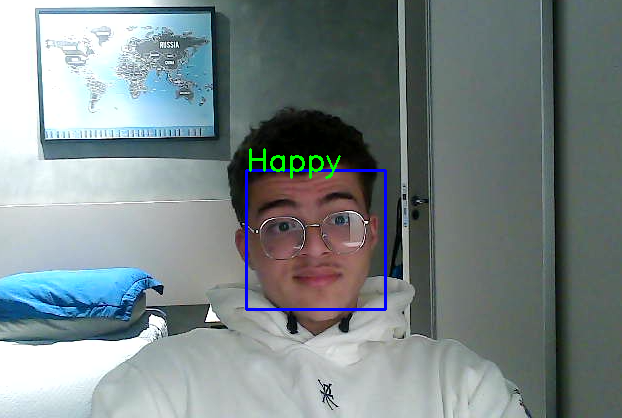

## 1. Data analysis

We're gonna explore our data and decide which steps we should take next...

So let's focus in a few questions to have a direction about what to see in our data:

* Is our images already in a format ready to use?
* Is there any missing data?
* Is there any discrepancy about our amount of data?

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
data = pd.read_csv("drive/MyDrive/Datasets/Facial expression/fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [5]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

**Note:** Our data has six classes: Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral.

We are going to use only **Angry, Happy, Sad and Surprise**. The reason is that disgust has almost no images, but for Disgust and Fear images aren't good, so would only confuse our model.

In [7]:
class_names = ["Angry", "Happy", "Sad", "Neutral"]

In [7]:
def plot_data(data, classes):

  values = data["emotion"].value_counts().sort_index(ascending=True)
  colors = ["lightgreen", "blue", "lightblue", "pink", "orange", "yellow", "purple"]

  plt.figure(figsize=[12, 5])

  plt.bar(x=classes, height=values, color=colors, edgecolor='black')

  plt.xlabel("Emotions")
  plt.ylabel("Amount")
  plt.title("Amount of emotions")
  plt.show();

In [6]:
plot_data(data, class_names)

NameError: ignored

Looks like we have some discrepancy in our data values...


Let's see if we have any missing values

In [8]:
data.isna().value_counts()

emotion  pixels  Usage
False    False   False    35887
dtype: int64

We don't have any missing data, which is good.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


Our images seems kinda strange, doesn't? Probably we need to make some changes in their format to be able to use with TensorFlow...

## 2. Data preprocessing

As we saw before in **Data Analysis section**, we have some problems with our data, so we're gonna make need to make some changes:

* Drop data with disgust emotions, cause' we have too little samples, if we undersample other emotions to be equal to 'disgust' length, will be too little data.

* Drop data with fear and neutral emotions, cause' their images aren't good and confuse our model. (I know this after some tests)

In [10]:
data = data[data["emotion"] != 1]
data = data[data["emotion"] != 2]
data = data[data["emotion"] != 5]
#data = data[data["emotion"] != 6]
data["emotion"].value_counts().reset_index(drop=True, inplace=True)

In [12]:
data[:10]

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
10,0,30 24 21 23 25 25 49 67 84 103 120 125 130 139...,Training
11,6,39 75 78 58 58 45 49 48 103 156 81 45 41 38 49...,Training
12,6,219 213 206 202 209 217 216 215 219 218 223 23...,Training


In [11]:
# Split data into X & y
X = data.drop("emotion", axis=1)
y = data["emotion"]

# Concat train sets into one
df = pd.concat([X, y], axis=1)

In [13]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
0    4953
Name: emotion, dtype: int64

In [14]:
# A few functions to help us process our pixels
def pixels_to_array(pixels):
    array = np.array(pixels.split(),'float64')
    return array

def image_reshape(data):
    image = np.reshape(data.to_list(),(data.shape[0],48,48,1))
    image = np.repeat(image, 3, -1)
    return image

In [15]:
df['pixels'] = df["pixels"].apply(pixels_to_array)

In [16]:
data_train = df[df["Usage"] == "Training"]
data_test1 = df[df["Usage"] == "PublicTest"]
data_test2 = df[df["Usage"] == "PrivateTest"]
data_test = pd.concat([data_test1, data_test2])

In [17]:
X_train = image_reshape(data_train["pixels"])
X_test = image_reshape(data_test["pixels"])
y_train = data_train["emotion"]
y_test = data_test["emotion"]

In [ ]:
set(y_train)

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(X_train[0])

In [18]:
!mkdir data
!mkdir data/train
!mkdir data/test

In [19]:
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
y_train

In [20]:
for i in range(len(y_train)):
  if y_train[i] == 3:
    y_train[i] = 1
  elif y_train[i] == 4:
    y_train[i] = 2
  # elif y_train[i] == 5:
  #   y_train[i] = 3
  elif y_train[i] == 6:
    y_train[i] = 3

for i in range(len(y_test)):
  if y_test[i] == 3:
    y_test[i] = 1
  elif y_test[i] == 4:
    y_test[i] = 2
  # elif y_test[i] == 5:
  #   y_test[i] = 3
  elif y_test[i] == 6:
    y_test[i] = 3

<ipython-input-20-0c437cbcacd1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[i] = 2
<ipython-input-20-0c437cbcacd1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[i] = 3
<ipython-input-20-0c437cbcacd1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[i] = 1
<ipython-input-20-0c437cbcacd1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

In [ ]:
len(X_train)

In [ ]:
y_train

Now let's put our images in their respective directories to after this be able to process in a better way

In [21]:
import cv2
import os

def put_in_dir(X_train, X_test, y_train, y_test, classes):
  """
  Takes data and dir to put images in directory.

  Args:

    data (np.array): Images
    dir (str): Directory to put images

  Returns:
    Images in the specified directory;

  """
  for label in range(len(classes)):
    os.makedirs("/content/data/train/" + classes[label], exist_ok=True)
    os.makedirs("/content/data/test/" + classes[label], exist_ok=True)

  for i in range(len(X_train)):
    emotion = classes[y_train[i]]
    cv2.imwrite(f"/content/data/train/{emotion}/{emotion}{i}.png", X_train[i])

  for j in range(len(X_test)):
    emotion = classes[y_test[j]]
    cv2.imwrite(f"/content/data/test/{emotion}/{emotion}{j}.png", X_test[j])

In [22]:
put_in_dir(X_train, X_test, y_train, y_test, class_names)

Below we are going to normalize our data, make data augmentation and transform data into batches.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (48, 48)
BATCH_SIZE = 32

train_dir = "/content/data/train/"
test_dir =  "/content/data/test/"

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.5,
                                   zoom_range=0.5)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size=IMAGE_SHAPE,
                                                batch_size=BATCH_SIZE,
                                                class_mode="categorical",
                                                # shuffle=True,
                                                save_to_dir=train_dir,
                                               save_prefix="N",
                                               save_format="jpg")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 21005 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.


## 3. Build CNN model

In [24]:
# Import packages
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

In [25]:
# batch size 64
tf.random.set_seed(42)
# Create the model
model_1 = Sequential([
  tf.keras.layers.Input(shape=(48, 48, 3)),
  tf.keras.layers.Conv2D(512, (3,3), activation="relu", padding="same"),
  BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
  BatchNormalization(),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
  BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
  BatchNormalization(),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4, activation="softmax")
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint/",
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=8, min_lr=0.00001)

# Fit the model
model_1.fit(train_data, epochs=45, callbacks=[reduce_lr, checkpoint_callback], validation_data=test_data)

Epoch 1/45
657/657 [==============================] - ETA: 0s - loss: 1.5403 - accuracy: 0.3065
Epoch 1: val_loss improved from inf to 1.35210, saving model to checkpoint/


657/657 [==============================] - 89s 110ms/step - loss: 1.5403 - accuracy: 0.3065 - val_loss: 1.3521 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 2/45
657/657 [==============================] - ETA: 0s - loss: 1.3644 - accuracy: 0.3374
Epoch 2: val_loss improved from 1.35210 to 1.34653, saving model to checkpoint/


657/657 [==============================] - 72s 109ms/step - loss: 1.3644 - accuracy: 0.3374 - val_loss: 1.3465 - val_accuracy: 0.3402 - lr: 0.0010
Epoch 3/45
657/657 [==============================] - ETA: 0s - loss: 1.3574 - accuracy: 0.3398
Epoch 3: val_loss did not improve from 1.34653
657/657 [==============================] - 72s 109ms/step - loss: 1.3574 - accuracy: 0.3398 - val_loss: 1.3537 - val_accuracy: 0.3402 - lr: 0.0010
Epoch 4/45
657/657 [==============================] - ETA: 0s - loss: 1.3483 - accuracy: 0.3440
Epoch 4: val_loss improved from 1.34653 to 1.33324, saving model to checkpoint/


657/657 [==============================] - 73s 111ms/step - loss: 1.3483 - accuracy: 0.3440 - val_loss: 1.3332 - val_accuracy: 0.3431 - lr: 0.0010
Epoch 5/45
657/657 [==============================] - ETA: 0s - loss: 1.3353 - accuracy: 0.3510
Epoch 5: val_loss did not improve from 1.33324
657/657 [==============================] - 69s 105ms/step - loss: 1.3353 - accuracy: 0.3510 - val_loss: 1.3650 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 6/45
657/657 [==============================] - ETA: 0s - loss: 1.3028 - accuracy: 0.3647
Epoch 6: val_loss improved from 1.33324 to 1.24295, saving model to checkpoint/


657/657 [==============================] - 70s 107ms/step - loss: 1.3028 - accuracy: 0.3647 - val_loss: 1.2430 - val_accuracy: 0.4012 - lr: 0.0010
Epoch 7/45
657/657 [==============================] - ETA: 0s - loss: 1.2587 - accuracy: 0.4112
Epoch 7: val_loss improved from 1.24295 to 1.18795, saving model to checkpoint/


657/657 [==============================] - 72s 110ms/step - loss: 1.2587 - accuracy: 0.4112 - val_loss: 1.1880 - val_accuracy: 0.4505 - lr: 0.0010
Epoch 8/45
657/657 [==============================] - ETA: 0s - loss: 1.2225 - accuracy: 0.4324
Epoch 8: val_loss did not improve from 1.18795
657/657 [==============================] - 68s 104ms/step - loss: 1.2225 - accuracy: 0.4324 - val_loss: 1.2108 - val_accuracy: 0.4676 - lr: 0.0010
Epoch 9/45
657/657 [==============================] - ETA: 0s - loss: 1.1841 - accuracy: 0.4623
Epoch 9: val_loss improved from 1.18795 to 1.04405, saving model to checkpoint/


657/657 [==============================] - 71s 108ms/step - loss: 1.1841 - accuracy: 0.4623 - val_loss: 1.0440 - val_accuracy: 0.5409 - lr: 0.0010
Epoch 10/45
657/657 [==============================] - ETA: 0s - loss: 1.1517 - accuracy: 0.4817
Epoch 10: val_loss did not improve from 1.04405
657/657 [==============================] - 68s 104ms/step - loss: 1.1517 - accuracy: 0.4817 - val_loss: 1.0829 - val_accuracy: 0.5430 - lr: 0.0010
Epoch 11/45
657/657 [==============================] - ETA: 0s - loss: 1.1205 - accuracy: 0.4973
Epoch 11: val_loss improved from 1.04405 to 1.03980, saving model to checkpoint/


657/657 [==============================] - 71s 108ms/step - loss: 1.1205 - accuracy: 0.4973 - val_loss: 1.0398 - val_accuracy: 0.5397 - lr: 0.0010
Epoch 12/45
657/657 [==============================] - ETA: 0s - loss: 1.1060 - accuracy: 0.5075
Epoch 12: val_loss improved from 1.03980 to 0.99067, saving model to checkpoint/


657/657 [==============================] - 72s 109ms/step - loss: 1.1060 - accuracy: 0.5075 - val_loss: 0.9907 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 13/45
657/657 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.5237
Epoch 13: val_loss improved from 0.99067 to 0.96027, saving model to checkpoint/


657/657 [==============================] - 71s 108ms/step - loss: 1.0871 - accuracy: 0.5237 - val_loss: 0.9603 - val_accuracy: 0.5831 - lr: 0.0010
Epoch 14/45
657/657 [==============================] - ETA: 0s - loss: 1.0665 - accuracy: 0.5322
Epoch 14: val_loss improved from 0.96027 to 0.93977, saving model to checkpoint/


657/657 [==============================] - 71s 108ms/step - loss: 1.0665 - accuracy: 0.5322 - val_loss: 0.9398 - val_accuracy: 0.6011 - lr: 0.0010
Epoch 15/45
657/657 [==============================] - ETA: 0s - loss: 1.0557 - accuracy: 0.5362
Epoch 15: val_loss improved from 0.93977 to 0.91946, saving model to checkpoint/


657/657 [==============================] - 72s 110ms/step - loss: 1.0557 - accuracy: 0.5362 - val_loss: 0.9195 - val_accuracy: 0.6051 - lr: 0.0010
Epoch 16/45
657/657 [==============================] - ETA: 0s - loss: 1.0342 - accuracy: 0.5486
Epoch 16: val_loss improved from 0.91946 to 0.91420, saving model to checkpoint/


657/657 [==============================] - 72s 110ms/step - loss: 1.0342 - accuracy: 0.5486 - val_loss: 0.9142 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 17/45
657/657 [==============================] - ETA: 0s - loss: 1.0180 - accuracy: 0.5575
Epoch 17: val_loss improved from 0.91420 to 0.90427, saving model to checkpoint/


657/657 [==============================] - 71s 107ms/step - loss: 1.0180 - accuracy: 0.5575 - val_loss: 0.9043 - val_accuracy: 0.6130 - lr: 0.0010
Epoch 18/45
657/657 [==============================] - ETA: 0s - loss: 1.0102 - accuracy: 0.5686
Epoch 18: val_loss did not improve from 0.90427
657/657 [==============================] - 69s 105ms/step - loss: 1.0102 - accuracy: 0.5686 - val_loss: 0.9223 - val_accuracy: 0.6019 - lr: 0.0010
Epoch 19/45
657/657 [==============================] - ETA: 0s - loss: 1.0057 - accuracy: 0.5643
Epoch 19: val_loss did not improve from 0.90427
657/657 [==============================] - 70s 106ms/step - loss: 1.0057 - accuracy: 0.5643 - val_loss: 0.9387 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 20/45
657/657 [==============================] - ETA: 0s - loss: 0.9936 - accuracy: 0.5731
Epoch 20: val_loss improved from 0.90427 to 0.88107, saving model to checkpoint/


657/657 [==============================] - 72s 109ms/step - loss: 0.9936 - accuracy: 0.5731 - val_loss: 0.8811 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 21/45
657/657 [==============================] - ETA: 0s - loss: 0.9813 - accuracy: 0.5797
Epoch 21: val_loss improved from 0.88107 to 0.85669, saving model to checkpoint/


657/657 [==============================] - 72s 109ms/step - loss: 0.9813 - accuracy: 0.5797 - val_loss: 0.8567 - val_accuracy: 0.6422 - lr: 0.0010
Epoch 22/45
657/657 [==============================] - ETA: 0s - loss: 0.9725 - accuracy: 0.5869
Epoch 22: val_loss improved from 0.85669 to 0.85184, saving model to checkpoint/


657/657 [==============================] - 73s 111ms/step - loss: 0.9725 - accuracy: 0.5869 - val_loss: 0.8518 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 23/45
657/657 [==============================] - ETA: 0s - loss: 0.9603 - accuracy: 0.5934
Epoch 23: val_loss did not improve from 0.85184
657/657 [==============================] - 69s 104ms/step - loss: 0.9603 - accuracy: 0.5934 - val_loss: 0.8691 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 24/45
657/657 [==============================] - ETA: 0s - loss: 0.9590 - accuracy: 0.5926
Epoch 24: val_loss improved from 0.85184 to 0.84595, saving model to checkpoint/


657/657 [==============================] - 74s 112ms/step - loss: 0.9590 - accuracy: 0.5926 - val_loss: 0.8459 - val_accuracy: 0.6477 - lr: 0.0010
Epoch 25/45
657/657 [==============================] - ETA: 0s - loss: 0.9447 - accuracy: 0.5968
Epoch 25: val_loss did not improve from 0.84595
657/657 [==============================] - 70s 107ms/step - loss: 0.9447 - accuracy: 0.5968 - val_loss: 0.8501 - val_accuracy: 0.6462 - lr: 0.0010
Epoch 26/45
657/657 [==============================] - ETA: 0s - loss: 0.9347 - accuracy: 0.6082
Epoch 26: val_loss did not improve from 0.84595
657/657 [==============================] - 69s 105ms/step - loss: 0.9347 - accuracy: 0.6082 - val_loss: 0.9445 - val_accuracy: 0.6147 - lr: 0.0010
Epoch 27/45
657/657 [==============================] - ETA: 0s - loss: 0.9359 - accuracy: 0.6034
Epoch 27: val_loss did not improve from 0.84595
657/657 [==============================] - 72s 109ms/step - loss: 0.9359 - accuracy: 0.6034 - val_loss: 0.8629 - val_accurac

657/657 [==============================] - 75s 114ms/step - loss: 0.9216 - accuracy: 0.6147 - val_loss: 0.8329 - val_accuracy: 0.6541 - lr: 0.0010
Epoch 31/45
657/657 [==============================] - ETA: 0s - loss: 0.9121 - accuracy: 0.6160
Epoch 31: val_loss did not improve from 0.83294
657/657 [==============================] - 72s 110ms/step - loss: 0.9121 - accuracy: 0.6160 - val_loss: 0.8373 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 32/45
657/657 [==============================] - ETA: 0s - loss: 0.9221 - accuracy: 0.6127
Epoch 32: val_loss improved from 0.83294 to 0.81015, saving model to checkpoint/


657/657 [==============================] - 73s 111ms/step - loss: 0.9221 - accuracy: 0.6127 - val_loss: 0.8102 - val_accuracy: 0.6616 - lr: 0.0010
Epoch 33/45
657/657 [==============================] - ETA: 0s - loss: 0.9130 - accuracy: 0.6185
Epoch 33: val_loss did not improve from 0.81015
657/657 [==============================] - 72s 110ms/step - loss: 0.9130 - accuracy: 0.6185 - val_loss: 0.8404 - val_accuracy: 0.6527 - lr: 0.0010
Epoch 34/45
657/657 [==============================] - ETA: 0s - loss: 0.9071 - accuracy: 0.6208
Epoch 34: val_loss did not improve from 0.81015
657/657 [==============================] - 69s 106ms/step - loss: 0.9071 - accuracy: 0.6208 - val_loss: 0.8351 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 35/45
657/657 [==============================] - ETA: 0s - loss: 0.9119 - accuracy: 0.6200
Epoch 35: val_loss did not improve from 0.81015
657/657 [==============================] - 72s 110ms/step - loss: 0.9119 - accuracy: 0.6200 - val_loss: 0.8403 - val_accurac

657/657 [==============================] - 72s 109ms/step - loss: 0.8908 - accuracy: 0.6301 - val_loss: 0.8018 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 40/45
657/657 [==============================] - ETA: 0s - loss: 0.8879 - accuracy: 0.6279
Epoch 40: val_loss improved from 0.80180 to 0.79811, saving model to checkpoint/


657/657 [==============================] - 76s 116ms/step - loss: 0.8879 - accuracy: 0.6279 - val_loss: 0.7981 - val_accuracy: 0.6692 - lr: 0.0010
Epoch 41/45
657/657 [==============================] - ETA: 0s - loss: 0.8843 - accuracy: 0.6329
Epoch 41: val_loss improved from 0.79811 to 0.79649, saving model to checkpoint/


657/657 [==============================] - 73s 111ms/step - loss: 0.8843 - accuracy: 0.6329 - val_loss: 0.7965 - val_accuracy: 0.6642 - lr: 0.0010
Epoch 42/45
657/657 [==============================] - ETA: 0s - loss: 0.8790 - accuracy: 0.6370
Epoch 42: val_loss did not improve from 0.79649
657/657 [==============================] - 73s 111ms/step - loss: 0.8790 - accuracy: 0.6370 - val_loss: 0.8046 - val_accuracy: 0.6717 - lr: 0.0010
Epoch 43/45
657/657 [==============================] - ETA: 0s - loss: 0.8762 - accuracy: 0.6402
Epoch 43: val_loss did not improve from 0.79649
657/657 [==============================] - 71s 108ms/step - loss: 0.8762 - accuracy: 0.6402 - val_loss: 0.8010 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 44/45
657/657 [==============================] - ETA: 0s - loss: 0.8761 - accuracy: 0.6369
Epoch 44: val_loss did not improve from 0.79649
657/657 [==============================] - 74s 112ms/step - loss: 0.8761 - accuracy: 0.6369 - val_loss: 0.8153 - val_accurac

657/657 [==============================] - 73s 112ms/step - loss: 0.8662 - accuracy: 0.6418 - val_loss: 0.7871 - val_accuracy: 0.6769 - lr: 0.0010


In [26]:
model_1.save("model.h5")

In [ ]:
!zip -r /content/file.zip /content/checkpoint

  adding: content/checkpoint/ (stored 0%)
  adding: content/checkpoint/saved_model.pb (deflated 89%)
  adding: content/checkpoint/keras_metadata.pb (deflated 93%)
  adding: content/checkpoint/variables/ (stored 0%)
  adding: content/checkpoint/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/checkpoint/variables/variables.index (deflated 72%)
  adding: content/checkpoint/assets/ (stored 0%)
